In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, accuracy_score
import matplotlib.pyplot as plt

NPZ_PATH = "../data/combined_preprocessed_os.npz"  
IMG_SIZE = 256
NUM_CLASSES = 5
BATCH_SIZE = 32

EPOCHS_A = 15
EPOCHS_B = 20
LR_A = 1e-3
LR_B = 1e-5
UNFREEZE_LAST = 150


In [2]:
data = np.load(NPZ_PATH, allow_pickle=True)
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val     = data["X_val"],   data["y_val"]
X_test, y_test   = data["X_test"],  data["y_test"]

print("Train:", X_train.shape, np.bincount(y_train))
print("Val  :", X_val.shape,   np.bincount(y_val))
print("Test :", X_test.shape,  np.bincount(y_test))


Train: (4832, 256, 256, 3) [1809 1239  903  212  669]
Val  : (763, 256, 256, 3) [388  88 194  46  47]
Test : (764, 256, 256, 3) [388  89 194  45  48]


In [ ]:
counts = np.bincount(y_train, minlength=NUM_CLASSES).astype(np.float32)
inv = 1.0 / np.maximum(counts, 1.0)
inv *= NUM_CLASSES / inv.sum()

class_weight = {i: float(inv[i]) for i in range(NUM_CLASSES)}
class_weight[1] *= 1.6
class_weight[4] *= 1.6

print("Class weights:", class_weight)

Class weights: {0: 0.31846269965171814, 1: 0.743953561782837, 2: 0.6379834413528442, 3: 2.7174484729766846, 4: 1.377815341949463}


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from cbam import CBAM 

def build_model(img_size=256, num_classes=5):
    inp = layers.Input((img_size, img_size, 3))
    base = keras.applications.efficientnet_v2.EfficientNetV2S(
        include_top=False, weights="imagenet", input_tensor=inp
    )
    x = base.output
    x = CBAM(reduction_ratio=16, name="cbam1")(x) 
    x = CBAM(reduction_ratio=16, name="cbam2")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.35)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inp, out, name="EffNetV2S_DoubleCBAM")


In [5]:
import importlib, cbam
importlib.reload(cbam)
from cbam import CBAM
print("CBAM from:", cbam.__file__)

CBAM from: c:\Users\pc\Projects\RetinopathyDetection\models\cbam.py


In [6]:
import tensorflow as tf
from tensorflow import keras

SMOOTH_EPS = 0.05  
NUM_CLASSES = 5 

def sparse_ce_with_label_smoothing(eps=SMOOTH_EPS, num_classes=NUM_CLASSES):
    cce = keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=eps)
    @tf.function
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_oh = tf.one_hot(y_true, depth=num_classes)
        return cce(y_true_oh, y_pred)
    return loss_fn


In [17]:
model = build_model()
for l in model.layers:
    if "efficientnetv2-s" in l.name:
        l.trainable = False

# Stage A
optA  = keras.optimizers.Adam(LR_A)
lossA = sparse_ce_with_label_smoothing(SMOOTH_EPS, NUM_CLASSES)
model.compile(optimizer=optA, loss=lossA, metrics=["accuracy"])

cbA = [
    keras.callbacks.ModelCheckpoint("stageA_best.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
]

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=EPOCHS_A,
          batch_size=BATCH_SIZE,
          class_weight=class_weight,
          callbacks=cbA)


Epoch 1/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5474 - loss: 0.8811
Epoch 1: val_accuracy improved from -inf to 0.59633, saving model to stageA_best.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 632s 4s/step - accuracy: 0.5478 - loss: 0.8804 - val_accuracy: 0.5963 - val_loss: 1.1197 - learning_rate: 0.0010
Epoch 2/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7083 - loss: 0.6410
Epoch 2: val_accuracy did not improve from 0.59633
151/151 ━━━━━━━━━━━━━━━━━━━━ 488s 3s/step - accuracy: 0.7083 - loss: 0.6410 - val_accuracy: 0.5465 - val_loss: 1.5542 - learning_rate: 0.0010
Epoch 3/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8029 - loss: 0.5220
Epoch 3: val_accuracy did not improve from 0.59633
151/151 ━━━━━━━━━━━━━━━━━━━━ 490s 3s/step - accuracy: 0.8028 - loss: 0.5220 - val_accuracy: 0.5138 - val_loss: 1.6778 - learning_rate: 0.0010
Epoch 4/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8653 - loss: 0.4172
Epoch 4: val_accuracy did not improve from 0.


StageA  Val Acc: 0.7562254259501966
StageA  Val QWK: 0.8364335666727861
              precision    recall  f1-score   support

           0     0.8575    0.9459    0.8995       388
           1     0.5714    0.3182    0.4088        88
           2     0.7026    0.7062    0.7044       194
           3     0.4030    0.5870    0.4779        46
           4     0.7500    0.3830    0.5070        47

    accuracy                         0.7562       763
   macro avg     0.6569    0.5880    0.5995       763
weighted avg     0.7511    0.7562    0.7437       763



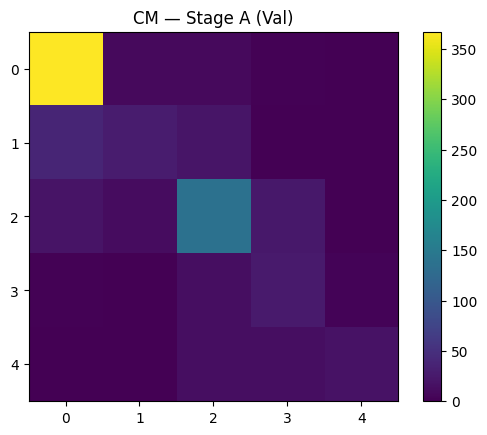

In [7]:
from tensorflow import keras
from cbam import CBAM
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

data = np.load("../data/combined_preprocessed_os.npz", allow_pickle=True)
X_val, y_val = data["X_val"], data["y_val"]

bestA = keras.models.load_model("stageA_best.keras",
                                custom_objects={"custom>CBAM": CBAM, "CBAM": CBAM},
                                compile=False)
p = bestA.predict(X_val, batch_size=32, verbose=0).argmax(1)
print("StageA  Val Acc:", accuracy_score(y_val, p))
print("StageA  Val QWK:", cohen_kappa_score(y_val, p, weights="quadratic"))
print(classification_report(y_val, p, digits=4))
cm = confusion_matrix(y_val, p, labels=[0,1,2,3,4])
plt.imshow(cm); plt.title("CM — Stage A (Val)"); plt.colorbar(); plt.show()


In [12]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf
from cbam import CBAM

def build_model(img_size=256, num_classes=5, return_backbone=False):
    inp = layers.Input((img_size, img_size, 3))
    base = keras.applications.efficientnet_v2.EfficientNetV2S(
        include_top=False, weights="imagenet", input_tensor=inp
    )
    x = base.output
    x = CBAM(reduction_ratio=16, name="cbam1")(x)
    x = CBAM(reduction_ratio=16, name="cbam2")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.35)(x)
    out = layers.Dense(5, activation="softmax", dtype="float32")(x)
    m = keras.Model(inp, out, name="EffNetV2S_DoubleCBAM")
    return (m, base) if return_backbone else m

loadedA = keras.models.load_model(
    "stageA_best.keras",
    custom_objects={"custom>CBAM": CBAM, "CBAM": CBAM},
    compile=False
)

model, backbone = build_model(return_backbone=True)

model.set_weights(loadedA.get_weights())
del loadedA

UNFREEZE_LAST = 160
backbone.trainable = True
for l in backbone.layers[:-UNFREEZE_LAST]:
    l.trainable = False
for l in backbone.layers:
    if isinstance(l, layers.BatchNormalization):
        l.trainable = False

SMOOTH_EPS = 0.05
NUM_CLASSES = 5
def sparse_ce_with_label_smoothing(eps=SMOOTH_EPS, num_classes=NUM_CLASSES):
    cce = keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=eps)
    @tf.function
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_oh = tf.one_hot(y_true, depth=num_classes)
        return cce(y_true_oh, y_pred)
    return loss_fn

LR_B = 1e-5
optB  = keras.optimizers.Adam(learning_rate=LR_B, global_clipnorm=1.0)
lossB = sparse_ce_with_label_smoothing(SMOOTH_EPS, NUM_CLASSES)
model.compile(optimizer=optB, loss=lossB, metrics=["accuracy"])

cbB = [
    keras.callbacks.ModelCheckpoint("stageB_best.keras", monitor="val_accuracy",
                                    save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7)
]

data = np.load("../data/combined_preprocessed_os.npz", allow_pickle=True)
counts = np.bincount(data["y_train"], minlength=5).astype(np.float32)
inv = 1.0 / np.maximum(counts, 1.0); inv *= 5 / inv.sum()
class_weight = {i: float(inv[i]) for i in range(5)}
class_weight[1] *= 1.6; class_weight[4] *= 1.6
print("class_weight:", class_weight)

histB = model.fit(
    data["X_train"], data["y_train"],
    validation_data=(data["X_val"], data["y_val"]),
    epochs=20,
    batch_size=32,
    class_weight=class_weight,
    callbacks=cbB,
    verbose=1
)


class_weight: {0: 0.31846269965171814, 1: 0.743953561782837, 2: 0.6379834413528442, 3: 2.7174484729766846, 4: 1.377815341949463}
Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9974 - loss: 0.1731
Epoch 1: val_accuracy improved from -inf to 0.75229, saving model to stageB_best.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.9974 - loss: 0.1731 - val_accuracy: 0.7523 - val_loss: 0.9929 - learning_rate: 1.0000e-05
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9960 - loss: 0.1733
Epoch 2: val_accuracy did not improve from 0.75229
151/151 ━━━━━━━━━━━━━━━━━━━━ 455s 3s/step - accuracy: 0.9960 - loss: 0.1733 - val_accuracy: 0.7523 - val_loss: 0.9915 - learning_rate: 1.0000e-05
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9973 - loss: 0.1737
Epoch 3: val_accuracy did not improve from 0.75229
151/151 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.9973 - loss: 0.1737 - val_accuracy: 0.7497 - val_loss: 0.9924 - learning_rate: 


=== [Val] stageA_best.keras ===
Acc: 0.7562 | QWK: 0.8364 | F1-macro: 0.5995
              precision    recall  f1-score   support

           0     0.8575    0.9459    0.8995       388
           1     0.5714    0.3182    0.4088        88
           2     0.7026    0.7062    0.7044       194
           3     0.4030    0.5870    0.4779        46
           4     0.7500    0.3830    0.5070        47

    accuracy                         0.7562       763
   macro avg     0.6569    0.5880    0.5995       763
weighted avg     0.7511    0.7562    0.7437       763



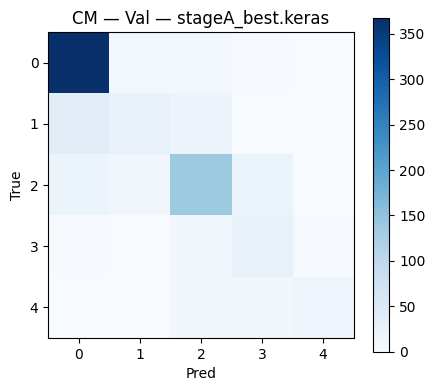


=== [Test] stageA_best.keras ===
Acc: 0.7435 | QWK: 0.8493 | F1-macro: 0.5738
              precision    recall  f1-score   support

           0     0.8717    0.9459    0.9073       388
           1     0.5111    0.2584    0.3433        89
           2     0.6601    0.6907    0.6751       194
           3     0.3699    0.6000    0.4576        45
           4     0.7727    0.3542    0.4857        48

    accuracy                         0.7435       764
   macro avg     0.6371    0.5698    0.5738       764
weighted avg     0.7402    0.7435    0.7296       764



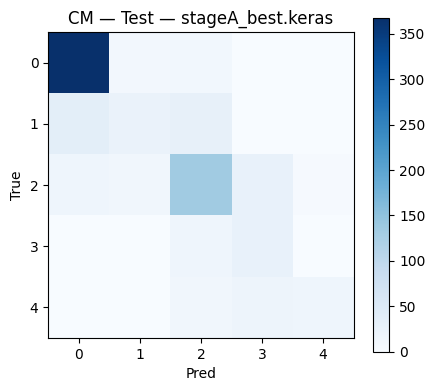


=== [Val] stageB_best.keras ===
Acc: 0.7523 | QWK: 0.8231 | F1-macro: 0.5859
              precision    recall  f1-score   support

           0     0.8460    0.9485    0.8943       388
           1     0.5625    0.3068    0.3971        88
           2     0.6915    0.7165    0.7038       194
           3     0.4182    0.5000    0.4554        46
           4     0.7083    0.3617    0.4789        47

    accuracy                         0.7523       763
   macro avg     0.6453    0.5667    0.5859       763
weighted avg     0.7397    0.7523    0.7365       763



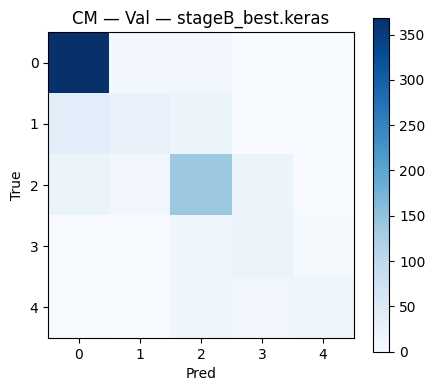


=== [Test] stageB_best.keras ===
Acc: 0.7461 | QWK: 0.8438 | F1-macro: 0.5666
              precision    recall  f1-score   support

           0     0.8645    0.9536    0.9069       388
           1     0.4889    0.2472    0.3284        89
           2     0.6557    0.7165    0.6847       194
           3     0.3898    0.5111    0.4423        45
           4     0.8000    0.3333    0.4706        48

    accuracy                         0.7461       764
   macro avg     0.6398    0.5523    0.5666       764
weighted avg     0.7357    0.7461    0.7283       764



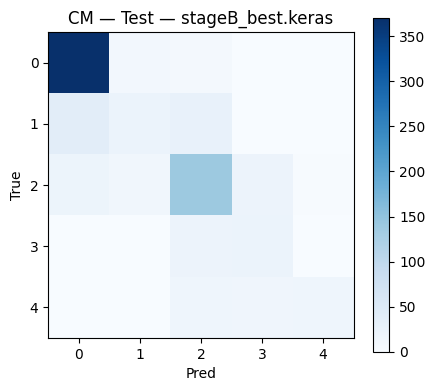

In [ ]:
import os, numpy as np, matplotlib.pyplot as plt
from tensorflow import keras
from cbam import CBAM
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix, f1_score

NPZ_PATH = "../data/combined_preprocessed_os.npz"  
data = np.load(NPZ_PATH, allow_pickle=True)
splits = {
    "Val":  (data["X_val"],  data["y_val"]),
    "Test": (data["X_test"], data["y_test"])
}

CHECKPOINTS = ["stageA_best.keras", "stageB_best.keras", "stageB_best_qwk.keras"]
custom = {"custom>CBAM": CBAM, "CBAM": CBAM}

def eval_checkpoint(path, X, y, split_name):
    m = keras.models.load_model(path, custom_objects=custom, compile=False)
    y_prob = m.predict(X, batch_size=32, verbose=0)
    y_pred = y_prob.argmax(1)

    acc  = accuracy_score(y, y_pred)
    qwk  = cohen_kappa_score(y, y_pred, weights="quadratic")
    f1m  = f1_score(y, y_pred, average="macro")

    print(f"\n=== [{split_name}] {path} ===")
    print(f"Acc: {acc:.4f} | QWK: {qwk:.4f} | F1-macro: {f1m:.4f}")
    print(classification_report(y, y_pred, digits=4))

    cm = confusion_matrix(y, y_pred, labels=[0,1,2,3,4])
    plt.figure(figsize=(4.5,4))
    plt.imshow(cm, interpolation='nearest', cmap="Blues")
    plt.title(f"CM — {split_name} — {os.path.basename(path)}")
    plt.colorbar()
    plt.xticks(range(5), range(5))
    plt.yticks(range(5), range(5))
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return acc, qwk, f1m

for ckpt in CHECKPOINTS:
    if os.path.exists(ckpt):
        for split_name, (X, y) in splits.items():
            eval_checkpoint(ckpt, X, y, split_name)



== Baseline avec TTA (sans biais) ==
[Val] Acc=0.7628 | QWK=0.8324
[Test] Acc=0.7565 | QWK=0.8646
 Acc=0.7628 | QWK=0.8324
 Acc=0.7615 | QWK=0.8312
 Acc=0.7615 | QWK=0.8312
 Acc=0.7628 | QWK=0.8326
 Acc=0.7628 | QWK=0.8326
 Acc=0.7641 | QWK=0.8333
 Acc=0.7628 | QWK=0.8372
 Acc=0.7615 | QWK=0.8410
 Acc=0.7602 | QWK=0.8329
 Acc=0.7588 | QWK=0.8307
 Acc=0.7575 | QWK=0.8296
 Acc=0.7575 | QWK=0.8296
 Acc=0.7588 | QWK=0.8309
 Acc=0.7588 | QWK=0.8309
 Acc=0.7602 | QWK=0.8317
 Acc=0.7588 | QWK=0.8355
 Acc=0.7575 | QWK=0.8394
 Acc=0.7562 | QWK=0.8313
 Acc=0.7549 | QWK=0.8290
 Acc=0.7536 | QWK=0.8279
 Acc=0.7536 | QWK=0.8279
 Acc=0.7549 | QWK=0.8293
 Acc=0.7549 | QWK=0.8293
 Acc=0.7562 | QWK=0.8300
 Acc=0.7549 | QWK=0.8339
 Acc=0.7536 | QWK=0.8377
 Acc=0.7523 | QWK=0.8297
 Acc=0.7549 | QWK=0.8289
 Acc=0.7536 | QWK=0.8278
 Acc=0.7536 | QWK=0.8278
 Acc=0.7549 | QWK=0.8291
 Acc=0.7549 | QWK=0.8291
 Acc=0.7562 | QWK=0.8299
 Acc=0.7549 | QWK=0.8338
 Acc=0.7536 | QWK=0.8376
 Acc=0.7523 | QWK=0.8296
 

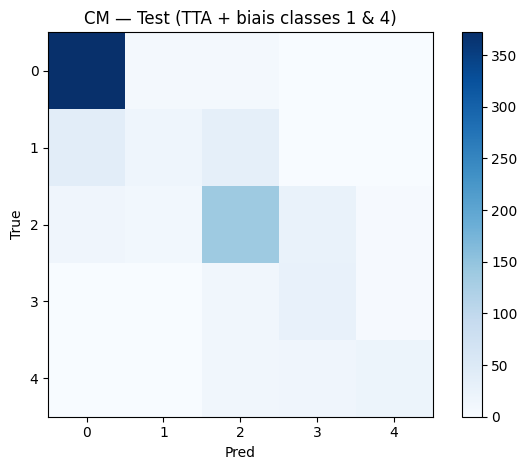

In [7]:
import numpy as np, matplotlib.pyplot as plt, os
from tensorflow import keras
from cbam import CBAM
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix

# === Chargement data & modèle (prends le meilleur QWK actuel : Stage A) ===
NPZ_PATH = "../data/combined_preprocessed_os.npz"   # ou ../data/combined_preprocessed.npz
data = np.load(NPZ_PATH, allow_pickle=True)
Xv, yv = data["X_val"],  data["y_val"]
Xt, yt = data["X_test"], data["y_test"]

custom = {"custom>CBAM": CBAM, "CBAM": CBAM}
MODEL_PATH = "stageA_best.keras"      # QWK le plus haut dans tes logs
model = keras.models.load_model(MODEL_PATH, custom_objects=custom, compile=False)

# === TTA: moyenne (x, flip(x)) ===
def predict_tta(m, X, batch_size=32):
    p0 = m.predict(X, batch_size=batch_size, verbose=0)
    Xf = X[:, :, ::-1, :].copy()
    p1 = m.predict(Xf, batch_size=batch_size, verbose=0)
    return (p0 + p1) / 2.0

pv = predict_tta(model, Xv)
pt = predict_tta(model, Xt)

def eval_probs(y_true, probs, title=""):
    y_pred = probs.argmax(1)
    acc = accuracy_score(y_true, y_pred)
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    print(f"{title} Acc={acc:.4f} | QWK={qwk:.4f}")
    return acc, qwk, y_pred

print("== Baseline avec TTA (sans biais) ==")
_, qwk_val_base, _ = eval_probs(yv, pv, title="[Val]")
_, qwk_tst_base, _ = eval_probs(yt, pt, title="[Test]")

# === Calibration: ajout d'un biais sur logits des classes 1 et 4 ===
def add_bias(probs, bias):
    """bias: dict {cls: delta_logit}. On convertit en logits, on ajoute, puis softmax."""
    z = np.log(np.clip(probs, 1e-9, 1.0))
    for c, b in bias.items():
        z[:, c] += b
    # re-softmax
    z = z - z.max(axis=1, keepdims=True)
    ez = np.exp(z)
    return ez / ez.sum(axis=1, keepdims=True)

# grid simple sur validation pour trouver le meilleur biais
candidates = np.linspace(0.0, 0.8, 9)   # 0, 0.1, ..., 0.8
best = {"qwk": -1, "b1": 0.0, "b4": 0.0}
for b1 in candidates:
    for b4 in candidates:
        pv_b = add_bias(pv, {1: b1, 4: b4})
        _, qvk, _ = eval_probs(yv, pv_b, title="")
        if qvk > best["qwk"]:
            best = {"qwk": qvk, "b1": float(b1), "b4": float(b4)}

print(f"\n>>> Biais choisi sur Val (max QWK): class1=+{best['b1']}, class4=+{best['b4']}  | Val QWK={best['qwk']:.4f}")

# applique au Test
pt_b = add_bias(pt, {1: best["b1"], 4: best["b4"]})
acc_v, qwk_v, ypv = eval_probs(yv, add_bias(pv, {1: best["b1"], 4: best["b4"]}), title="[Val+biais]")
acc_t, qwk_t, ypt = eval_probs(yt, pt_b, title="[Test+biais]")

# Rapport détaillé (Test)
print("\n=== Classification report [Test+biais] ===")
print(classification_report(yt, ypt, digits=4))
cm = confusion_matrix(yt, ypt, labels=[0,1,2,3,4])
plt.imshow(cm, cmap="Blues"); plt.colorbar()
plt.title("CM — Test (TTA + biais classes 1 & 4)")
plt.xticks(range(5), range(5)); plt.yticks(range(5), range(5))
plt.xlabel("Pred"); plt.ylabel("True")
plt.tight_layout(); plt.show()


>>> Meilleur biais (Val): 0:-0.15  1:+0.00  4:+0.70  | Val QWK=0.8394

[Val]  Acc=0.7562  QWK=0.8394
              precision    recall  f1-score   support

           0     0.8481    0.9356    0.8897       388
           1     0.5750    0.2614    0.3594        88
           2     0.7039    0.7474    0.7250       194
           3     0.4717    0.5435    0.5051        46
           4     0.5833    0.4468    0.5060        47

    accuracy                         0.7562       763
   macro avg     0.6364    0.5869    0.5970       763
weighted avg     0.7409    0.7562    0.7398       763



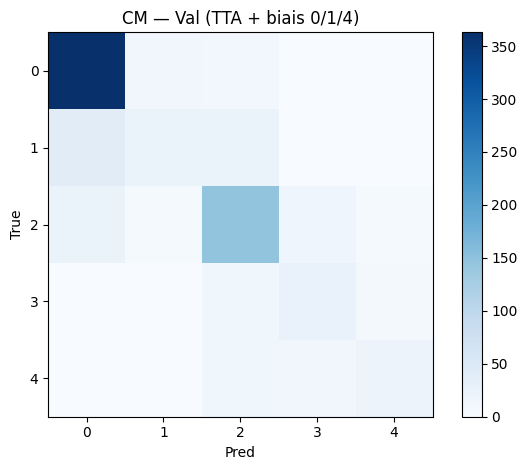


[Test]  Acc=0.7592  QWK=0.8623
              precision    recall  f1-score   support

           0     0.8753    0.9588    0.9151       388
           1     0.4865    0.2022    0.2857        89
           2     0.6792    0.7423    0.7094       194
           3     0.4194    0.5778    0.4860        45
           4     0.7143    0.4167    0.5263        48

    accuracy                         0.7592       764
   macro avg     0.6349    0.5795    0.5845       764
weighted avg     0.7432    0.7592    0.7399       764



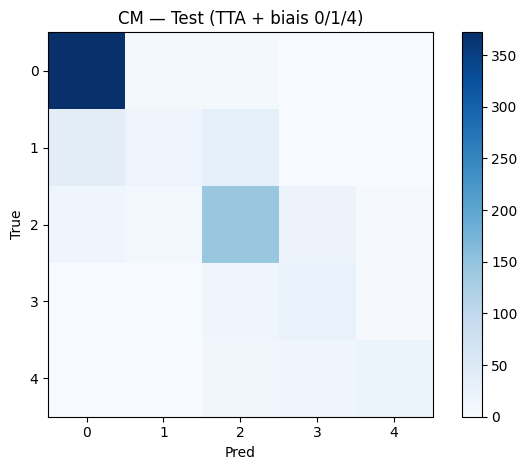

In [8]:
import numpy as np, itertools, os, matplotlib.pyplot as plt
from tensorflow import keras
from cbam import CBAM
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix

# --- Données ---
NPZ_PATH = "../data/combined_preprocessed_os.npz"
data = np.load(NPZ_PATH, allow_pickle=True)
Xv, yv = data["X_val"],  data["y_val"]
Xt, yt = data["X_test"], data["y_test"]

# --- Modèles (Stage A obligatoire, Stage B optionnel si dispo) ---
custom = {"custom>CBAM": CBAM, "CBAM": CBAM}
mA = keras.models.load_model("stageA_best.keras", custom_objects=custom, compile=False)
pAv = mA.predict(Xv, batch_size=32, verbose=0); pAt = mA.predict(Xt, batch_size=32, verbose=0)

pBv = pBt = None
if os.path.exists("stageB_best.keras"):
    mB = keras.models.load_model("stageB_best.keras", custom_objects=custom, compile=False)
    pBv = mB.predict(Xv, batch_size=32, verbose=0); pBt = mB.predict(Xt, batch_size=32, verbose=0)

def tta_avg(pX, model):
    p0 = model.predict(pX, batch_size=32, verbose=0)
    p1 = model.predict(pX[:, :, ::-1, :].copy(), batch_size=32, verbose=0)
    return (p0 + p1) / 2.0

# TTA
pAv = tta_avg(Xv, mA); pAt = tta_avg(Xt, mA)
if pBv is not None:
    pBv = tta_avg(Xv, mB); pBt = tta_avg(Xt, mB)

# --- Ensemble (optionnel) ---
def blend(pA, pB, w=0.6):
    return w*pA + (1-w)*pB if pB is not None else pA

pV_base = blend(pAv, pBv, w=0.6)   # 60% StageA, 40% StageB si B existe
pT_base = blend(pAt, pBt, w=0.6)

# --- Appliquer biais sur logits ---
def apply_bias(probs, bias):  # bias: dict {cls: +delta_logit}
    z = np.log(np.clip(probs, 1e-9, 1.0))
    for c, b in bias.items(): z[:, c] += b
    z = z - z.max(axis=1, keepdims=True)
    ez = np.exp(z)
    return ez / ez.sum(axis=1, keepdims=True)

def eval_probs(y, p):
    yhat = p.argmax(1)
    acc = accuracy_score(y, yhat)
    qwk = cohen_kappa_score(y, yhat, weights="quadratic")
    return acc, qwk, yhat

# --- Grid search 3D sur Val: δ0∈{0..0.3}, δ1∈{0..0.6}, δ4∈{0..0.8} ---
grid0 = np.linspace(0.0, 0.30, 7)  # pénalité 0 : on soustraira δ0
grid1 = np.linspace(0.0, 0.60, 7)  # boost 1
grid4 = np.linspace(0.0, 0.80, 9)  # boost 4

best = {"qwk": -1, "d0": 0.0, "d1": 0.0, "d4": 0.0}
for d0, d1, d4 in itertools.product(grid0, grid1, grid4):
    pv = apply_bias(pV_base, {0: -d0, 1: d1, 4: d4})
    _, qvk, _ = eval_probs(yv, pv)
    if qvk > best["qwk"]:
        best.update({"qwk": qvk, "d0": float(d0), "d1": float(d1), "d4": float(d4)})

print(f">>> Meilleur biais (Val): 0:-{best['d0']:.2f}  1:+{best['d1']:.2f}  4:+{best['d4']:.2f}  | Val QWK={best['qwk']:.4f}")

# --- Évaluation finale Val/Test avec ce biais ---
pV_final = apply_bias(pV_base, {0: -best["d0"], 1: best["d1"], 4: best["d4"]})
pT_final = apply_bias(pT_base, {0: -best["d0"], 1: best["d1"], 4: best["d4"]})

for tag, y, p in [("Val", yv, pV_final), ("Test", yt, pT_final)]:
    acc, qwk, yhat = eval_probs(y, p)
    print(f"\n[{tag}]  Acc={acc:.4f}  QWK={qwk:.4f}")
    print(classification_report(y, yhat, digits=4))
    cm = confusion_matrix(y, yhat, labels=[0,1,2,3,4])
    plt.imshow(cm, cmap="Blues"); plt.colorbar()
    plt.title(f"CM — {tag} (TTA + biais 0/1/4)")
    plt.xticks(range(5), range(5)); plt.yticks(range(5), range(5))
    plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout(); plt.show()


In [9]:
import json
bias = {"class_0": -0.15, "class_1": 0.0, "class_4": 0.7}
with open("inference_bias.json","w") as f: json.dump(bias, f)


In [10]:
import numpy as np, json
from tensorflow import keras
from cbam import CBAM

def predict_with_calibration(model_path, X, bias_json="inference_bias.json", bs=32):
    custom = {"custom>CBAM": CBAM, "CBAM": CBAM}
    m = keras.models.load_model(model_path, custom_objects=custom, compile=False)

    # TTA
    p0 = m.predict(X, batch_size=bs, verbose=0)
    p1 = m.predict(X[:, :, ::-1, :].copy(), batch_size=bs, verbose=0)
    p = (p0 + p1) / 2.0

    # Appliquer biais
    with open(bias_json) as f:
        b = json.load(f)
    z = np.log(np.clip(p, 1e-9, 1.0))
    for cls, d in b.items():
        c = int(cls.split("_")[1])
        z[:, c] += d
    z = z - z.max(axis=1, keepdims=True)
    ez = np.exp(z)
    pcal = ez / ez.sum(axis=1, keepdims=True)
    return pcal, pcal.argmax(1)


In [12]:
X_new = data["X_test"]  
y_new = data["y_test"]     

probs, preds = predict_with_calibration("stageA_best.keras", X_new)

print("Shape des prédictions:", probs.shape)
print("Labels prédits:", preds[:20])
print("Labels vrais:  ", y_new[:20])


Shape des prédictions: (764, 5)
Labels prédits: [3 3 0 2 2 0 2 1 0 2 0 0 0 0 0 1 2 2 2 2]
Labels vrais:   [3 2 0 2 1 0 2 1 0 4 0 0 0 0 1 1 2 2 1 2]


IMG_PATH: c:\Users\pc\Projects\RetinopathyDetection\data\test_images\e4dcca36ceb4.png


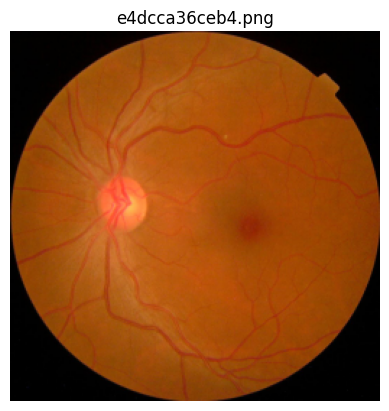

Probabilités: [0.94019556 0.00991728 0.01034317 0.01463769 0.02490632]
Classe prédite: 0


In [21]:
import os, cv2, numpy as np, matplotlib.pyplot as plt

# Choisis une image listée par la cellule 1, ex. files[0]
IMG_PATH = files[0]  # ou mets un chemin exact sous forme r"c:\....\img1.jpg"
print("IMG_PATH:", IMG_PATH)

def load_retina_image(path, img_size=256):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Fichier introuvable: {path}")
    img = cv2.imread(path)  # BGR
    if img is None:
        raise ValueError(f"cv2.imread a renvoyé None pour: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    img = img.astype("float32") / 255.0  # comme ton dataset
    return img

img = load_retina_image(IMG_PATH, img_size=256)
plt.imshow(img); plt.title(os.path.basename(IMG_PATH)); plt.axis("off"); plt.show()

# Empile en batch (1,256,256,3)
X_new = np.expand_dims(img, axis=0)

# Prédiction avec ta calibration (TTA + biais)
probs, preds = predict_with_calibration("stageA_best.keras", X_new)
print("Probabilités:", probs[0])
print("Classe prédite:", preds[0])


Dataset chargé: (764, 256, 256, 3) (764,)
             path  y_true  y_pred  correct       p_0       p_1       p_2  \
0  npz_test_0.png       3       3        1  0.013014  0.011760  0.186489   
1  npz_test_1.png       2       3        0  0.009752  0.006094  0.460758   
2  npz_test_2.png       0       0        1  0.943803  0.010926  0.015218   
3  npz_test_3.png       2       2        1  0.208410  0.084197  0.631638   
4  npz_test_4.png       1       2        0  0.006542  0.456954  0.520515   

        p_3       p_4  
0  0.756613  0.032126  
1  0.492848  0.030548  
2  0.012767  0.017285  
3  0.048669  0.027084  
4  0.004356  0.011633  
✅ Résultats sauvegardés -> predictions_batch.csv

Global: Acc=0.7552 | QWK=0.8601 | F1-macro=0.5849

Classification report:
              precision    recall  f1-score   support

           0     0.8750    0.9562    0.9138       388
           1     0.4865    0.2022    0.2857        89
           2     0.6780    0.7165    0.6967       194
           3    

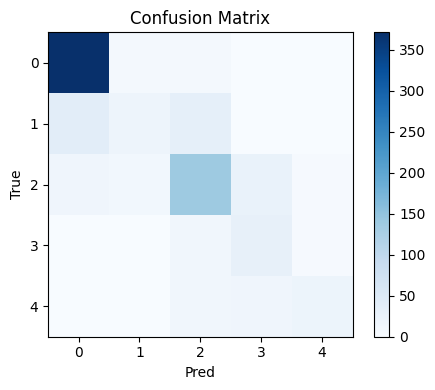

In [ ]:
MODE = "npz" 
NPZ_PATH = "../data/combined_preprocessed_os.npz" 
MODEL_PATH = "stageA_best.keras"
BIAS_JSON  = "inference_bias.json"
IMG_SIZE   = 256
BATCH_SIZE = 32

import os, glob, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tensorflow import keras
from cbam import CBAM
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix, f1_score
import cv2

def load_img(path, img_size=IMG_SIZE):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"cv2.imread a renvoyé None: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    return (img.astype("float32") / 255.0)

def predict_with_calibration(model_path, X, bias_json=BIAS_JSON, bs=BATCH_SIZE):
    custom = {"custom>CBAM": CBAM, "CBAM": CBAM}
    m = keras.models.load_model(model_path, custom_objects=custom, compile=False)
    p0 = m.predict(X, batch_size=bs, verbose=0)
    p1 = m.predict(X[:, :, ::-1, :].copy(), batch_size=bs, verbose=0)  # TTA flip H
    p  = (p0 + p1) / 2.0
    if os.path.exists(bias_json):
        with open(bias_json) as f:
            b = json.load(f)
        z = np.log(np.clip(p, 1e-9, 1.0))
        for k, d in b.items():  # {"class_0": -0.15, "class_4": 0.7}
            c = int(k.split("_")[1])
            z[:, c] += float(d)
        z = z - z.max(axis=1, keepdims=True)
        p = np.exp(z) / np.exp(z).sum(axis=1, keepdims=True)
    return p, p.argmax(1)

# ---------- charger X, y, paths selon MODE ----------
paths, X, y = None, None, None

if MODE == "dir":
    paths, y = [], []
    for cls in ["0","1","2","3","4"]:
        d = os.path.join(IMG_DIR, cls)
        for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff"):
            for f in glob.glob(os.path.join(d, ext)):
                paths.append(f); y.append(int(cls))
    if len(paths)==0:
        raise RuntimeError(f"Aucune image trouvée sous {IMG_DIR}\\[0-4]\\*.*")
    X = np.stack([load_img(p) for p in paths], axis=0)
    y = np.array(y, dtype=np.int32)

elif MODE == "csv":
    df = pd.read_csv(CSV_PATH)
    if not {"path","label"}.issubset(df.columns):
        raise ValueError("CSV doit contenir les colonnes: path,label")
    paths = df["path"].tolist()
    y = df["label"].astype(int).to_numpy()
    X = np.stack([load_img(p) for p in paths], axis=0)

elif MODE == "npz":
    data = np.load(NPZ_PATH, allow_pickle=True)
    X = data["X_test"]; y = data["y_test"]
    paths = [f"npz_test_{i}.png" for i in range(len(y))]  # placeholders pour la table
else:
    raise ValueError("MODE doit être 'dir', 'csv' ou 'npz'.")

print("Dataset chargé:", X.shape, y.shape)

# ---------- prédire ----------
probs, preds = predict_with_calibration(MODEL_PATH, X)

# ---------- tableau de résultats ----------
cols_prob = [f"p_{c}" for c in range(5)]
df_res = pd.DataFrame({
    "path": paths,
    "y_true": y,
    "y_pred": preds,
    "correct": (preds == y).astype(int)
})
df_probs = pd.DataFrame(probs, columns=cols_prob)
df_res = pd.concat([df_res, df_probs], axis=1)
print(df_res.head())

# Sauvegarde CSV
out_csv = "predictions_batch.csv"
df_res.to_csv(out_csv, index=False, encoding="utf-8")
print("✅ Résultats sauvegardés ->", out_csv)

# ---------- métriques globales ----------
acc  = accuracy_score(y, preds)
qwk  = cohen_kappa_score(y, preds, weights="quadratic")
f1m  = f1_score(y, preds, average="macro")
print(f"\nGlobal: Acc={acc:.4f} | QWK={qwk:.4f} | F1-macro={f1m:.4f}")
print("\nClassification report:")
print(classification_report(y, preds, digits=4))

cm = confusion_matrix(y, preds, labels=[0,1,2,3,4])
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues"); plt.colorbar()
plt.xticks(range(5), range(5)); plt.yticks(range(5), range(5))
plt.xlabel("Pred"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.tight_layout(); plt.show()
